# Run PESTPP-IES

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/flopy/flopy


In [2]:
t_d = "template"
m_d = "master_ies"

In [3]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
grss3,grss3,log,705,0,1,-1,0.5
vka7_cn,vka7_cn,log,1,0,1,-1,0.5
pp_ss0,pp_ss0,log,67,0,1,-1,0.5
grsy4,grsy4,log,705,0,0.243038,-0.60206,0.211275
grvka3,grvka3,log,705,0,1,-1,0.5
pp_hk2,pp_hk2,log,67,0,1,-1,0.5
pp_sy2,pp_sy2,log,67,0,0.243038,-0.60206,0.211275
grvka4,grvka4,log,705,0,1,-1,0.5
drncond_k00,drncond_k00,log,10,0,1,-1,0.5
sy8_cn,sy8_cn,log,1,0,0.243038,-0.60206,0.211275


### Run PESTPP-IES in original mode and post process

In [4]:
pst.pestpp_options["ies_num_reals"] = 30
pst.pestpp_options["ies_par_en"] = "sweep_in.csv"
pst.control_data.noptmax = 3

In [5]:
pst.write(os.path.join(t_d,"freyberg_ies.pst"))

In [6]:
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies.pst",num_slaves=20,master_dir=m_d)

In [7]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)

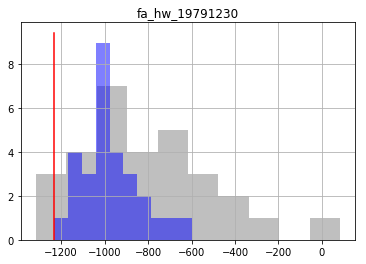

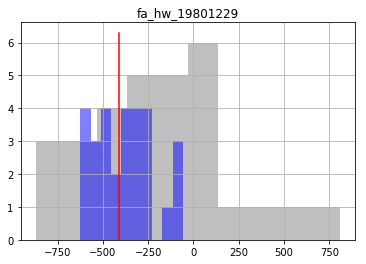

In [8]:
obs = pst.observation_data
swgws = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
for swgw in swgws:
    ax = plt.subplot(111)
    oe_pr.loc[:,swgw].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,swgw].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[swgw,"obsval"],obs.loc[swgw,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(swgw)
    plt.show()

In [9]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)

[0.1        0.73382444 1.36764889 2.00147333 2.63529778 3.26912222
 3.90294667 4.53677111 5.17059556 5.80442   ]
[0.532195 0.85349  0.708385 0.781125 0.873722 0.995894 1.4029   1.17187
 0.91937  1.55729  0.837298 0.993885 0.640764 0.652007 0.541983 0.656841
 0.761226 0.458938 0.512068 0.802092 2.28468  2.02528  1.31926  1.30407
 1.22782  1.0559   1.90377  1.53452  1.51682  4.25096  0.961127 0.700966
 0.475056 0.446303 0.414826 0.345056 0.457816 0.465162 0.406338 0.888281
 0.844292 0.803026 0.477246 0.573529 0.557607 0.696579 0.59334  0.454194
 0.458577 0.824203 0.505681 0.508551 0.341913 0.265645 0.323864 0.456233
 0.670669 0.410003 0.435609 0.6349   0.924358 0.681523 0.367261 0.367704
 0.510308 0.825585 0.684494 0.543695 0.80906  1.72681  1.17287  1.36174
 0.787856 0.969649 0.469148 0.44447  0.574844 0.490648 0.443378 0.714482
 0.993687 1.11079  0.537795 0.781409 0.744419 0.955895 0.911895 0.644049
 0.638797 1.54427  1.52335  1.61008  1.14754  0.951904 1.06838  1.27845
 1.72193  1.249

[0.321714   1.01762467 1.71353533 2.409446   3.10535667 3.80126733
 4.497178   5.19308867 5.88899933 6.58491   ]
[0.845573 4.49195  3.33115  2.2112   2.6125   2.79142  1.85957  3.66394
 2.37557  1.72426  3.03268  2.68887  1.50268  3.69801  1.69856  2.68237
 2.856    4.06471  1.65784  3.72437  2.48416  2.34995  1.52876  2.63621
 2.71183  2.50528  0.581713 1.27436  2.09315 ]
[0.321714   1.01762467 1.71353533 2.409446   3.10535667 3.80126733
 4.497178   5.19308867 5.88899933 6.58491   ]
[0.792765 1.9946   5.20483  3.15318  1.11789  1.00406  1.98146  1.30154
 1.11689  0.321714 0.444801 0.855233 0.852676 0.887428 0.983874 0.993564
 2.98227  2.25349  6.58491  0.762048 1.75053  2.03964  0.456704 0.548128
 0.731934 1.27005  0.824142 0.510895 0.350798 1.      ]
[0.206897   0.57407178 0.94124656 1.30842133 1.67559611 2.04277089
 2.40994567 2.77712044 3.14429522 3.51147   ]
[0.398927 0.874658 1.91209  0.743693 0.775049 0.629383 0.51747  2.13575
 1.12301  0.912359 1.54018  0.556144 0.640739 3.4729

[0.584497   0.71399733 0.84349767 0.972998   1.10249833 1.23199867
 1.361499   1.49099933 1.62049967 1.75      ]
[1.46349  1.75     1.06154  1.36397  1.24435  1.5259   0.915619 1.58257
 1.07254  1.14531  1.24781  1.1699   1.62596  0.821152 1.6636   0.998783
 1.32361  1.53     1.49095  1.66938  1.42089  1.4371   1.19428  1.57795
 1.64106  1.68354  1.06272  1.32186  1.26852 ]
[0.584497   0.71399733 0.84349767 0.972998   1.10249833 1.23199867
 1.361499   1.49099933 1.62049967 1.75      ]
[1.14616  0.88706  1.75     0.694239 0.829785 0.842724 1.47413  0.716316
 1.27775  0.824936 0.844123 1.14446  1.15771  1.57622  0.584497 1.28734
 0.75785  1.21626  1.75     1.75     0.855699 1.75     0.780166 0.967228
 1.09229  1.70519  0.966429 1.00472  0.89783  1.      ]
[0.500761   0.63956533 0.77836967 0.917174   1.05597833 1.19478267
 1.333587   1.47239133 1.61119567 1.75      ]
[0.515276 0.801104 0.960977 1.02454  0.852104 0.794571 0.87249  0.740793
 0.704933 0.916733 0.683538 0.90481  1.04827  0.57

<Figure size 576x756 with 0 Axes>

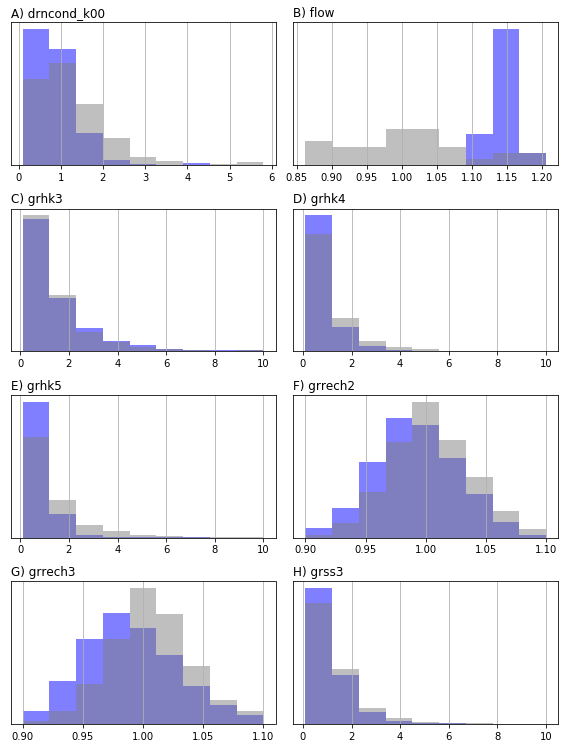

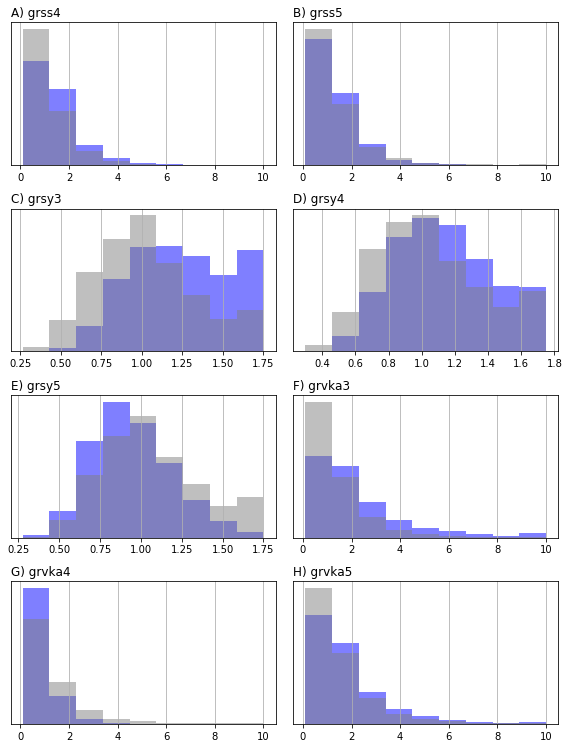

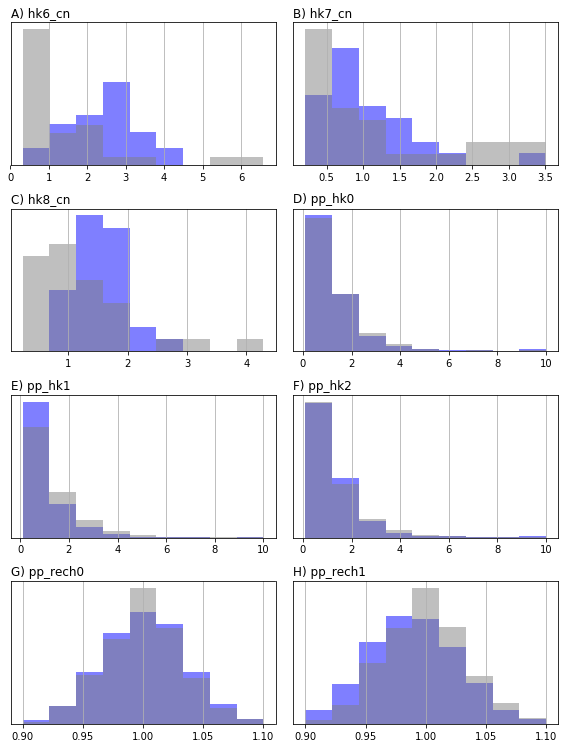

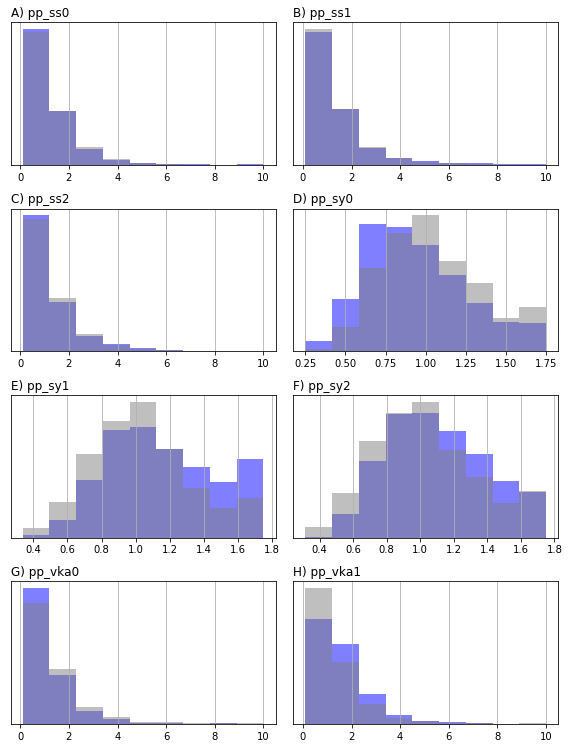

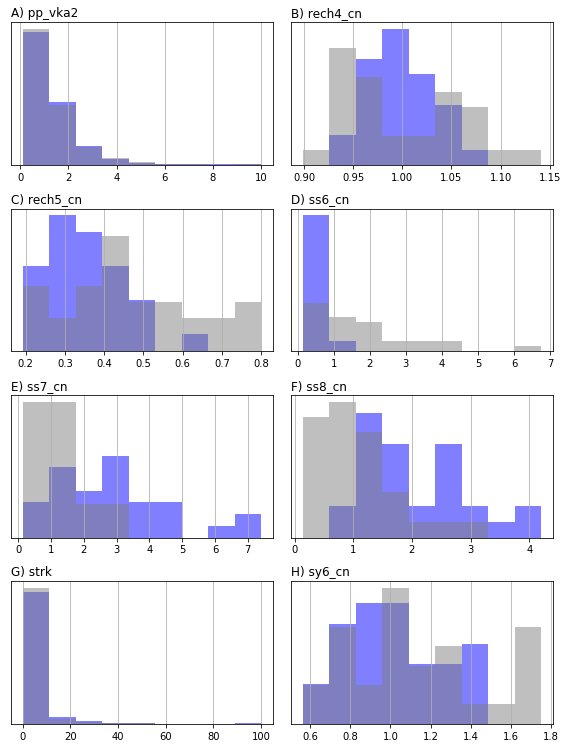

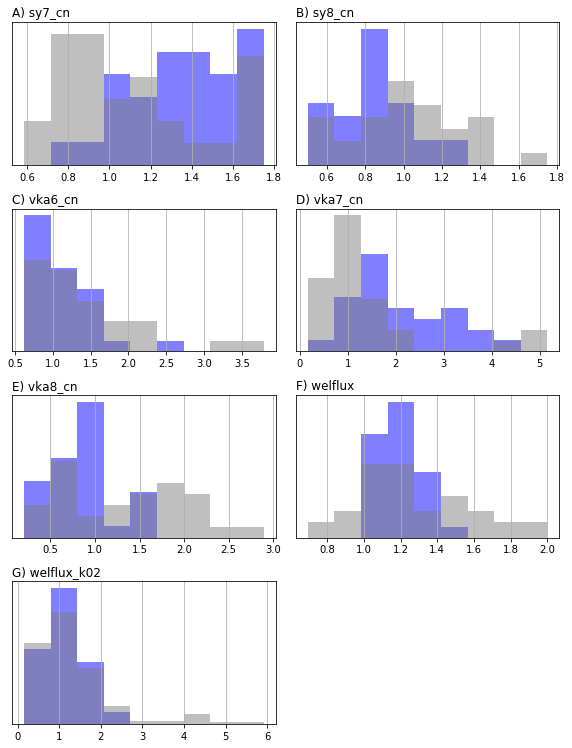

In [10]:
par = pst.parameter_data
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)

### PESTPP-IES with simple temporal localization

In [11]:
par = pst.parameter_data
scen_groups = ["grrech3","pp_rech1","rech5_cn"]
scen_pars = par.loc[par.pargp.apply(lambda x: x in scen_groups),"parnme"].tolist()
scen_pars.append("welflux_001")


In [12]:
loc = pyemu.Matrix.from_names(pst.nnz_obs_names,pst.par_groups).to_dataframe()
loc.loc[:,:]= 1.0
loc.loc[:,scen_groups] = 0.0
pyemu.Matrix.from_dataframe(loc).to_ascii(os.path.join(t_d,"loc.mat"))

In [13]:
pst.pestpp_options["ies_localizer"] = "loc.mat"
pst.write(os.path.join(t_d,"freyberg_ies_loc.pst"))
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies_loc.pst",num_slaves=20,master_dir=m_d)

In [14]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies_loc.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies_loc.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)

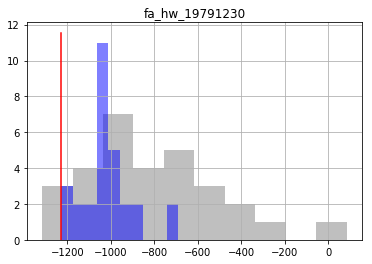

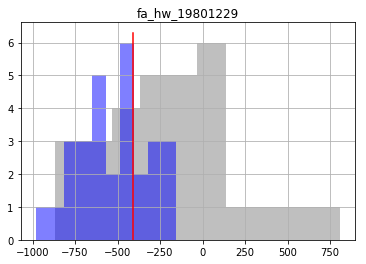

In [15]:
obs = pst.observation_data
swgws = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
for swgw in swgws:
    ax = plt.subplot(111)
    oe_pr.loc[:,swgw].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,swgw].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[swgw,"obsval"],obs.loc[swgw,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(swgw)
    plt.show()

### PESTPP-IES with par-by-par distance based localization

In [16]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws="template")


In [18]:
par = pst.parameter_data

gr_par = par.loc[par.pargp.apply(lambda x: "gr" in x),:].copy()
gr_par.groupby("pargp").groups
gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x[-6:-3]))
gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x[-3:]))
gr_par.loc[:,"x"] = gr_par.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
gr_par.loc[:,"y"] = gr_par.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)

obs = pst.observation_data

nobs = obs.loc[obs.obgnme=="calhead",:].copy()
nobs.loc[:,"i"] = nobs.obsnme.apply(lambda x: int(x.split('_')[2]))
nobs.loc[:,"j"] = nobs.obsnme.apply(lambda x: int(x.split('_')[3]))
nobs.loc[:,"x"] = nobs.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
nobs.loc[:,"y"] = nobs.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)

pp_tpl = [f for f in os.listdir(t_d) if "pp" in f and f.endswith(".tpl")]
pp_tpl_dfs = [pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(t_d,f)) for f in pp_tpl]
pp_par = pd.concat(pp_tpl_dfs)
pp_par.index = pp_par.parnme
#pp_par = par.loc[par.pargp.apply(lambda x: "pp" in x),:].copy()


In [20]:
loc = pyemu.Matrix.from_names(pst.nnz_obs_names,pst.par_names).to_dataframe()
loc.loc[:,:] = 1.0
loc_dist = 5000.0
for oname in obs.loc[obs.obgnme=="calhead","obsnme"]:
#     i,j = nobs.loc[oname,["i","j"]]
#     gr_par.loc[:,'idiff'] = (gr_par.i - i).apply(np.abs)
#     gr_par.loc[:,'jdiff'] = (gr_par.j - j).apply(np.abs)
#     print(oname,gr_par.idiff.min(),gr_par.jdiff.min())
#     too_far = gr_par.loc[gr_par.apply(lambda x: x.idiff > 4 or x.jdiff > 4,axis=1),"parnme"]
#     loc.loc[:,too_far] = 0.0
    xx,yy = nobs.loc[oname,['x','y']]
    
    gr_par.loc[:,"dist"] = gr_par.apply(lambda x: (x.x - xx)**2 + (x.y - yy)**2,axis=1).apply(np.sqrt)
    gr_too_far = gr_par.loc[gr_par.dist > loc_dist,"parnme"]
    loc.loc[:,gr_too_far] = 0.0
    
    pp_par.loc[:,"dist"] = pp_par.apply(lambda x: (x.x - xx)**2 + (x.y - yy)**2,axis=1).apply(np.sqrt)
    pp_too_far = pp_par.loc[pp_par.dist > loc_dist,"parnme"]
    loc.loc[oname,pp_too_far] = 0.0
    print(oname,gr_too_far.shape[0]/gr_par.shape[0],pp_too_far.shape[0]/pp_par.shape[0])
    
loc.loc[:,scen_pars] = 0.0
spars = par.loc[par.parnme.apply(lambda x: "ss" in x or "sy" in x),"parnme"]
loc.loc[:,spars] = 0.0
loc.sum(axis=1)

hds_00_002_009_000 0.46382978723404256 0.4925373134328358
hds_00_002_015_000 0.4794326241134752 0.5074626865671642
hds_00_003_008_000 0.43829787234042555 0.43283582089552236
hds_00_009_001_000 0.3304964539007092 0.2835820895522388
hds_00_013_010_000 0.15319148936170213 0.14925373134328357
hds_00_015_016_000 0.13900709219858157 0.11940298507462686
hds_00_021_010_000 0.06950354609929078 0.07462686567164178
hds_00_022_015_000 0.12198581560283688 0.13432835820895522
hds_00_024_004_000 0.17872340425531916 0.1791044776119403
hds_00_026_006_000 0.2198581560283688 0.208955223880597
hds_00_029_015_000 0.29929078014184396 0.29850746268656714
hds_00_033_007_000 0.3829787234042553 0.3880597014925373
hds_00_034_010_000 0.4 0.40298507462686567


fo_39_19791230        1059.0
hds_00_002_009_000     828.0
hds_00_002_015_000     821.0
hds_00_003_008_000     856.0
hds_00_009_001_000     926.0
hds_00_013_010_000     989.0
hds_00_015_016_000    1003.0
hds_00_021_010_000    1024.0
hds_00_022_015_000     996.0
hds_00_024_004_000     975.0
hds_00_026_006_000     961.0
hds_00_029_015_000     919.0
hds_00_033_007_000     877.0
hds_00_034_010_000     870.0
dtype: float64

In [21]:
pyemu.Matrix.from_dataframe(loc).to_binary(os.path.join(t_d,"loc.jcb"))
pst.pestpp_options["ies_localizer"] = "loc.jcb"
pst.write(os.path.join(t_d,"freyberg_ies_loc2.pst"))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
<class 'numpy.ndarray'>


In [22]:
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies_loc2.pst",num_slaves=20,master_dir=m_d)

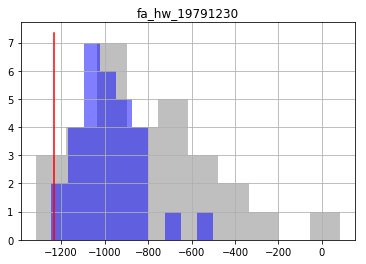

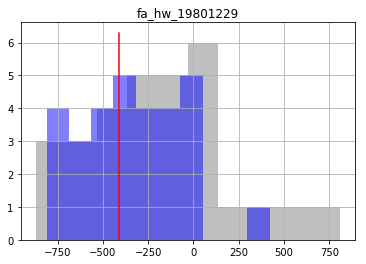

In [23]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies_loc2.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies_loc2.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
swgws = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
for swgw in swgws:
    ax = plt.subplot(111)
    oe_pr.loc[:,swgw].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,swgw].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[swgw,"obsval"],obs.loc[swgw,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(swgw)
    plt.show()